DAT310 Final Project - Allan Brett

My project goal is to attempt to train a neural network to differentiate between male and female walkers/runners based on hip biomechanical data. From our groups own analysis and published research we have shown that hip biomechanics vary (unsurprinsgly) between male and females, particularily in the transverse and frontal planes. 

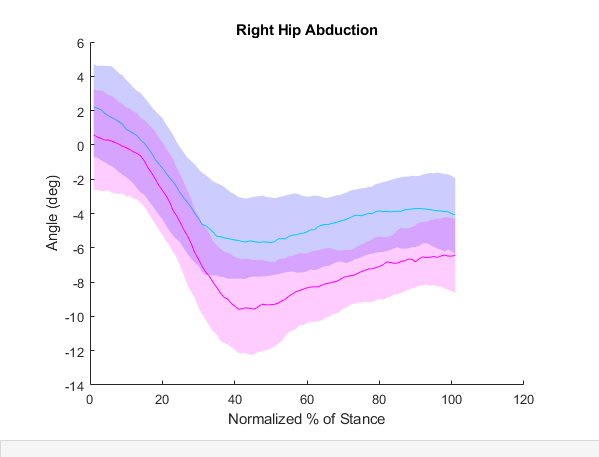

In [1]:
#To begin we will investigate hip adduction. A graph of hip adduction showing the differences between males and females is shown below. I hope to train a neural network to be able to classify a subject
#as male or female based on their hip adduction timeseries data. Note this is all data we are currently in the process of making open to the public so there are no ethical concerns and no data is
#identifiable to a person.

# Note the axes of the data

# X - AB /AD duction (Frontal plane)
# Y - Axial Rotation (Transverse plane)
# Z - Hinge flexion/extention (Saggital plane)

# So the data where we'd expect the most clear difference between male and females would be in the X position [0th index].

%matplotlib inline
from IPython.display import Image
Image('Project_img/right_hip_abd.PNG')


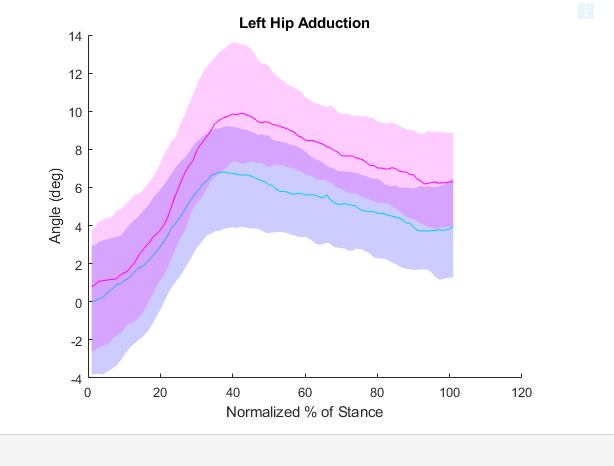

In [2]:
Image('Project_img/left_hip_abd.PNG')

PART I 

Data cleaning and Preparation

Note this data has been pre-processed slightly for ease of use. Typically a trial on the treadmill lasts about 30-60 seconds. However to make the file easier to upload, and to make the analysis more straightforward, the median angle for the whole trial was calculated and loaded into this dataset. 

In [3]:
#import required packages
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

#load in meta data
df_run_data = pd.read_csv('Project_data/run_data_meta.csv')
df_walk_data = pd.read_csv('Project_data/walk_data_meta.csv')

#show some basic data exploration
#will first use running data as angle differences are more pronounced than walking

#view data
df_run_data.head()

,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,SpecInjury2,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces
0,100433,2010-10-05 13:22:40,20101005T132240.json,1.610861,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,NaN,"walking, horseback riding, strength training",Recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN
1,100434,2010-11-17 13:22:40,20101117T132240.json,2.237294,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,NaN,"running, swimming",Recreational,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
2,100537,2012-07-03 10:25:50,20120703T102550.json,2.127441,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,NaN,"hiking, power walking, pilates",Recreational,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
3,100560,2012-07-17 10:37:48,20120717T103748.json,2.657365,33,179.3,83.0,Female,Right,No injury,...,NaN,Yoga,Recreational,NaN,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
4,101481,2012-07-17 10:50:21,20120717T105021.json,2.625088,32,176.3,58.6,Female,NaN,No injury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#describe dataset
df_run_data.describe()

,sub_id,speed_r,age,Height,Weight,InjDuration,YrsRunning,YrPR,NumRaces
count,1832.000000,1832.000000,1832.000000,1829.000000,1830.000000,405.000000,1315.000000,425.000000,504.000000
mean,122721.658843,2.760160,38.170306,173.051919,71.017223,450.471605,49.122624,1930.315294,5.329365
std,41154.448668,0.477627,13.145301,29.675143,37.466057,1662.403237,191.117688,394.518125,5.480369
min,100001.000000,1.172048,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100608.750000,2.482615,28.000000,165.200000,60.000000,60.000000,3.250000,2012.000000,2.000000
50%,101256.000000,2.721310,37.000000,172.700000,69.100000,120.000000,8.000000,2012.000000,4.000000
75%,101795.250000,2.933408,47.000000,179.000000,78.400000,365.000000,15.000000,2012.000000,8.000000
max,201225.000000,4.876998,255.000000,999.000000,1564.000000,30000.000000,999.000000,2016.000000,30.000000


In [5]:
#keep only necessary columns
df_run = df_run_data[['sub_id', 'datestring', 'filename', 'Gender','speed_r', 'age','Height',  'Weight']]

A few tasks should be completed before feeding data into the model so we can have the best chance of training the model successfuly

1) Remove outliers. This could be done analytically, however I will just set some bounds I know which mark acceptable data
2) Only use each subject once. Lots of subjects will have either multiple trials on the same day, or multiple trials across many days. Simply select the one closest to the average speed.
3) Select the gender with the fewest subjects (will be males). Then balance the dataset with equal males and females.


In [6]:
#Step 1 remove outliers by cutoff for speed, age, height, weight

df_run = df_run[df_run['speed_r'] > 2.2] #the walk/run transition speed is typically 1.9m/s. Set above to remove possible "fast walkers"
df_run = df_run[df_run_data['speed_r'] < 3] #running above 3m/s is quite fast so remove them
df_run = df_run[df_run['age'] < 60]      #use an age cutoff of 60. We don't want to analyze the elderly
df_run = df_run[df_run['Height'] < 200]  #remove subjects who are exceptionally tall (or data was entered incorrectly)
df_run = df_run[df_run['Weight'] < 100]  #remove subjects who are exceptionally large (or data was entered incorrectly)
df_run = df_run[df_run['Gender'].isin(['Male', 'Female'])] #remove subjects who likely had their gender entered incorrectly

df_run.describe()


C:\Users\allan\AppData\Local\Temp\ipykernel_10112\296110761.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_run = df_run[df_run_data['speed_r'] < 3] #running above 3m/s is quite fast so remove them


,sub_id,speed_r,age,Height,Weight
count,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000
mean,118320.339623,2.654919,37.144381,172.313011,69.537176
std,37904.151002,0.213228,10.978430,9.077408,11.844084
min,100001.000000,2.200815,18.000000,120.000000,43.800000
25%,100415.500000,2.494030,28.000000,165.250000,60.000000
50%,100993.000000,2.706884,37.000000,172.200000,68.500000
75%,101654.000000,2.798840,46.000000,179.000000,78.000000
max,201225.000000,2.997382,59.000000,196.500000,99.700000


In [7]:
# Step #1 got rid of 613 trials. Now on to step 2

#Step #2 remove duplicate subject data

mean_speed = df_run["speed_r"].mean()

#get unique ID list

unique_id_list = df_run["sub_id"].unique()

for i in range(len(unique_id_list)):
    unique_id = unique_id_list[i]
    sub_data = df_run[df_run['sub_id'].isin([unique_id])]

    if len(sub_data) > 1:
        #remove extras, keep one with speed closest to average
        idx = sub_data['speed_r'].sub(mean_speed).abs().idxmin()
        to_remove = sub_data[~sub_data.index.isin([idx])]
        df_run = df_run[~df_run['filename'].isin(to_remove['filename'].tolist())]

        del idx
        del sub_data

df_run.describe()
        

,sub_id,speed_r,age,Height,Weight
count,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000
mean,113533.519126,2.636088,37.462659,172.234481,69.732438
std,33251.061701,0.209075,10.981005,8.935551,11.896844
min,100001.000000,2.200815,18.000000,120.000000,43.800000
25%,100378.500000,2.485395,29.000000,165.500000,60.125000
50%,100843.000000,2.700660,37.000000,172.250000,68.500000
75%,101550.250000,2.759071,46.000000,179.000000,78.400000
max,201225.000000,2.996379,59.000000,196.500000,99.700000


In [8]:
#Split into males and females

df_male = df_run.loc[df_run['Gender'] == 'Male']
df_female = df_run.loc[df_run['Gender'] == 'Female']

In [9]:
df_male.describe()

,sub_id,speed_r,age,Height,Weight
count,511.000000,511.000000,511.000000,511.000000,511.000000
mean,116407.197652,2.692319,38.553816,178.458513,78.042779
std,36238.803737,0.192003,11.261967,6.594121,9.231242
min,100002.000000,2.215078,18.000000,157.000000,54.000000
25%,100373.000000,2.627018,30.000000,174.000000,71.750000
50%,100848.000000,2.718116,39.000000,178.700000,77.800000
75%,101626.500000,2.820971,48.000000,183.000000,84.450000
max,201225.000000,2.995937,59.000000,196.500000,99.700000


In [10]:
df_female.describe()

,sub_id,speed_r,age,Height,Weight
count,587.000000,587.000000,587.000000,587.000000,587.000000
mean,111031.901193,2.587138,36.512777,166.816286,62.498053
std,30221.825105,0.211161,10.649284,6.959787,8.839845
min,100001.000000,2.200815,18.000000,120.000000,43.800000
25%,100394.500000,2.419853,27.500000,162.650000,56.450000
50%,100826.000000,2.654482,37.000000,166.100000,61.600000
75%,101517.500000,2.729102,45.000000,171.500000,67.000000
max,201099.000000,2.996379,59.000000,187.500000,96.600000


In [11]:
# We can see from above that the dataset is slightly unbalanced. Balance dataset by removing "extra females" 

n_classes = 2
n_per_class = 511

under_samped_df = pd.DataFrame(columns=['filename', 'Gender_num'])
for i in df_run['Gender'].unique():
    under_samped_df = pd.concat([under_samped_df, df_run[df_run.Gender == i].iloc[:n_per_class,:]])


under_samped_df.describe()    

#under_samped_df = df_run

,sub_id,speed_r,age,Height,Weight
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,108618.015656,2.624894,37.603718,172.680920,70.255565
std,26774.049174,0.205598,10.932636,8.790791,11.788958
min,100001.000000,2.200815,18.000000,144.000000,43.800000
25%,100348.250000,2.481661,29.000000,166.000000,60.825000
50%,100797.500000,2.697641,38.000000,173.000000,69.250000
75%,101423.000000,2.744020,46.000000,179.200000,78.800000
max,201225.000000,2.995937,59.000000,196.500000,99.700000


Now let's split the datasets and double check that the dataset is now balanced

In [12]:
df_male_undersamp = under_samped_df.loc[under_samped_df['Gender'] == 'Male']
df_female_undersamp = under_samped_df.loc[under_samped_df['Gender'] == 'Female']

In [13]:
df_male_undersamp.describe()

,sub_id,speed_r,age,Height,Weight
count,511.000000,511.000000,511.000000,511.000000,511.000000
mean,116407.197652,2.692319,38.553816,178.458513,78.042779
std,36238.803737,0.192003,11.261967,6.594121,9.231242
min,100002.000000,2.215078,18.000000,157.000000,54.000000
25%,100373.000000,2.627018,30.000000,174.000000,71.750000
50%,100848.000000,2.718116,39.000000,178.700000,77.800000
75%,101626.500000,2.820971,48.000000,183.000000,84.450000
max,201225.000000,2.995937,59.000000,196.500000,99.700000


In [14]:
df_female_undersamp.describe()

,sub_id,speed_r,age,Height,Weight
count,511.000000,511.000000,511.000000,511.000000,511.000000
mean,100828.833659,2.557469,36.653620,166.903327,62.468351
std,522.944054,0.196594,10.518489,6.658305,8.455561
min,100001.000000,2.200815,18.000000,144.000000,43.800000
25%,100331.000000,2.377714,28.000000,163.000000,56.700000
50%,100743.000000,2.596678,37.000000,166.200000,61.600000
75%,101256.500000,2.714512,45.000000,171.500000,66.900000
max,101804.000000,2.988612,59.000000,187.500000,96.600000


We can see that the dataset is balanced. Now let's visualize the distribution of demographics for the two groups

<Axes: xlabel='Gender', ylabel='age'>

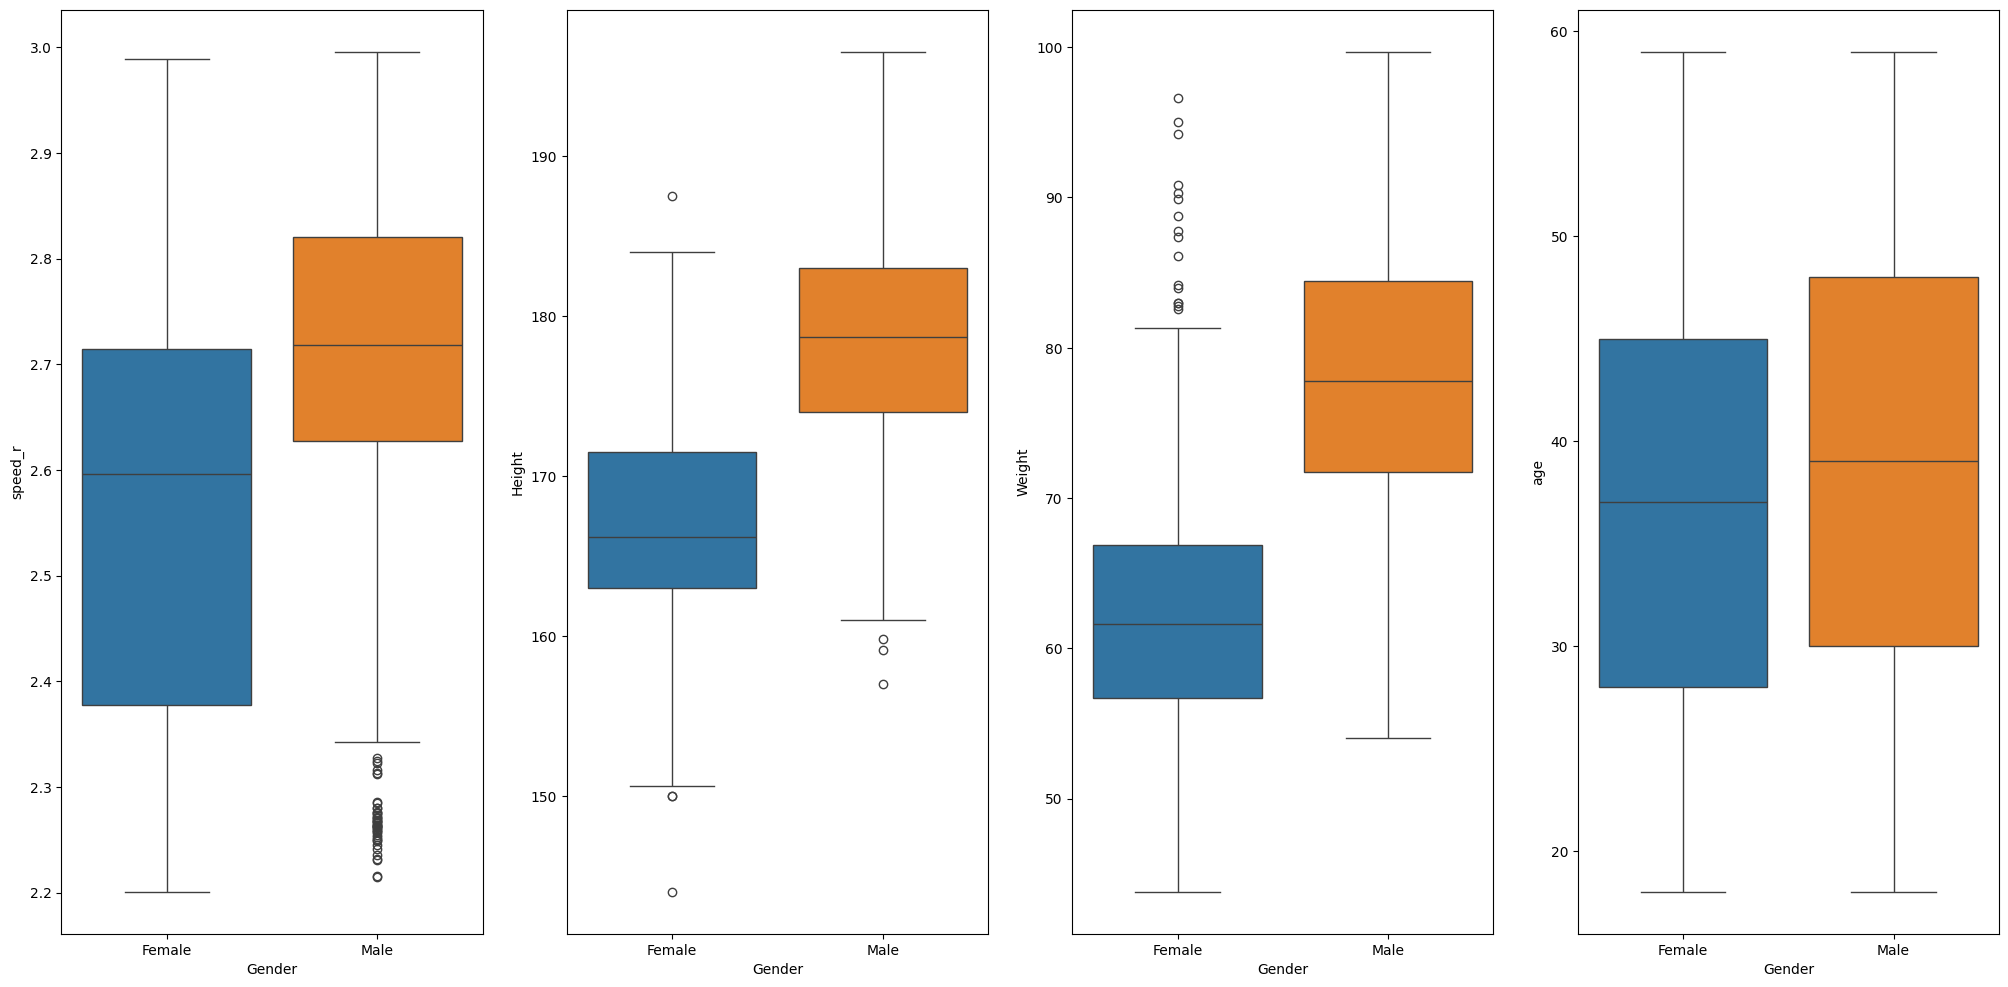

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=4, figsize = (25, 12))
sns.boxplot(ax=ax1, x = 'Gender', y = 'speed_r', hue = 'Gender', data = under_samped_df)
sns.boxplot(ax=ax2, x = 'Gender', y = 'Height', hue = 'Gender', data = under_samped_df)
sns.boxplot(ax=ax3, x = 'Gender', y = 'Weight', hue = 'Gender', data = under_samped_df)
sns.boxplot(ax=ax4, x = 'Gender', y = 'age', hue = 'Gender', data = under_samped_df)

Speed and age are quite reasonably matched. As would be expected however that height/weight are a little less matched between the groups. However this is to be expected as on average males and taller and heavier than females.

Next let's numerically encode the gender column.

In [16]:
# Numerically encode the Gender column
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
under_samped_df['Gender_num'] = LE.fit_transform(under_samped_df['Gender'])


under_samped_df.head()


,filename,Gender_num,sub_id,datestring,Gender,speed_r,age,Height,Weight
3,20120717T103748.json,0,100560.0,2012-07-17 10:37:48,Female,2.657365,33.0,179.3,83.0
4,20120717T105021.json,0,101481.0,2012-07-17 10:50:21,Female,2.625088,32.0,176.3,58.6
6,20120829T125604.json,0,100595.0,2012-08-29 12:56:04,Female,2.223969,50.0,154.6,64.5
8,20121122T140316.json,0,100658.0,2012-11-22 14:03:16,Female,2.434180,22.0,172.0,69.0
10,20130410T105446.json,0,100727.0,2013-04-10 10:54:46,Female,2.724679,22.0,170.0,63.0


Train test split

In [17]:
from sklearn.model_selection import train_test_split

#Train/test/split the data
X_train, X_test = train_test_split(under_samped_df, test_size=0.1, random_state=42)

In [18]:
#Investigate the split dataset
X_train.head()

,filename,Gender_num,sub_id,datestring,Gender,speed_r,age,Height,Weight
994,20140211T125515.json,0,100988.0,2014-02-11 12:55:15,Female,2.358658,44.0,169.3,67.2
871,20120913T120801.json,0,100605.0,2012-09-13 12:08:01,Female,2.352883,46.0,168.5,52.0
113,20150702T134211.json,1,101539.0,2015-07-02 13:42:11,Male,2.856233,37.0,179.0,81.4
899,20121213T120614.json,0,100670.0,2012-12-13 12:06:14,Female,2.493826,39.0,165.6,55.6
742,20110913T161805.json,1,100211.0,2011-09-13 16:18:05,Male,2.531581,25.0,189.0,76.1


In [19]:
X_train.describe()

,Gender_num,sub_id,speed_r,age,Height,Weight
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,0.501632,108734.783460,2.628456,37.571273,172.672905,70.089649
std,0.500270,26955.154193,0.204525,10.906869,8.822224,11.714300
min,0.000000,100002.000000,2.204163,18.000000,144.000000,43.800000
25%,0.000000,100347.000000,2.482561,29.000000,166.000000,60.750000
50%,1.000000,100796.000000,2.697836,38.000000,173.000000,69.000000
75%,1.000000,101427.500000,2.744922,46.000000,179.250000,78.600000
max,1.000000,201225.000000,2.992617,59.000000,196.500000,99.700000


In [20]:
X_train_male = X_train.loc[X_train['Gender'] == 'Male']
X_train_female = X_train.loc[X_train['Gender'] == 'Female']

X_test_male = X_test.loc[X_test['Gender'] == 'Male']
X_test_female = X_test.loc[X_test['Gender'] == 'Female']

In [21]:
X_train_male.describe()

,Gender_num,sub_id,speed_r,age,Height,Weight
count,461.0,461.000000,461.000000,461.000000,461.000000,461.000000
mean,1.0,116584.325380,2.698426,38.490239,178.413232,77.843948
std,0.0,36411.829145,0.188334,11.184151,6.629284,9.210932
min,1.0,100002.000000,2.215078,18.000000,157.000000,54.000000
25%,1.0,100375.000000,2.633930,30.000000,174.000000,71.300000
50%,1.0,100841.000000,2.720974,39.000000,178.500000,77.600000
75%,1.0,101629.000000,2.835237,48.000000,183.000000,84.200000
max,1.0,201225.000000,2.992617,59.000000,196.500000,99.700000


In [22]:
X_train_female.describe()

,Gender_num,sub_id,speed_r,age,Height,Weight
count,458.0,458.000000,458.000000,458.000000,458.000000,458.000000
mean,0.0,100833.825328,2.558028,36.646288,166.894978,62.284557
std,0.0,528.364232,0.195997,10.552018,6.738793,8.279149
min,0.0,100007.000000,2.204163,18.000000,144.000000,43.800000
25%,0.0,100326.500000,2.380346,28.000000,162.525000,56.700000
50%,0.0,100743.500000,2.596834,37.000000,166.350000,61.600000
75%,0.0,101266.750000,2.715570,45.000000,171.275000,66.775000
max,0.0,101804.000000,2.988612,59.000000,187.500000,96.600000


In [23]:
X_test_male.describe()

,Gender_num,sub_id,speed_r,age,Height,Weight
count,50.0,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.0,114774.080000,2.636007,39.140000,178.876000,79.876000
std,0.0,34914.572474,0.217091,12.059394,6.309324,9.309674
min,1.0,100004.000000,2.230886,19.000000,165.000000,59.000000
25%,1.0,100315.250000,2.474069,30.500000,175.000000,74.250000
50%,1.0,101044.000000,2.702886,37.500000,179.000000,80.200000
75%,1.0,101557.250000,2.779145,48.000000,182.000000,86.325000
max,1.0,201073.000000,2.995937,59.000000,194.000000,99.000000


In [24]:
X_test_female.describe()

,Gender_num,sub_id,speed_r,age,Height,Weight
count,53.0,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.0,100785.698113,2.552637,36.716981,166.975472,64.056604
std,0.0,475.956429,0.203536,10.322450,5.975202,9.795319
min,0.0,100001.000000,2.200815,18.000000,151.000000,47.800000
25%,0.0,100418.000000,2.367303,30.000000,164.000000,56.800000
50%,0.0,100726.000000,2.553746,37.000000,166.000000,61.900000
75%,0.0,101160.000000,2.708501,44.000000,172.000000,69.700000
max,0.0,101778.000000,2.944255,54.000000,179.500000,95.000000


We can see that there does exist a slight imbalance in the dataset after splitting. However 458 females to 461 males is acceptable for the training set.

Now write our model and test.

But first use GPU if available.

In [25]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Write Data loader

In [26]:
#Custom min/max scaler. Standard library cannot be used because the data consists of a sequence of timeseries data. The data cannot be scaled on itself, but instead the scaling must
#reflect the min/max of the entire dataset. 

def normalize(x, min_angle, max_angle):
    '''
    Function NORMALIZE: Returns a min/max normalize timeseries

        Params: x (arr): The input timeseries
                min_angle (int): The calcualted minimum angle of the dataset
                max_angle (int): The calculated maximum angle of the dataset

        Returns: (arr): min/max normalized timeseries

    '''
    
    return np.array([np.round((i - min_angle) / (max_angle - min_angle), 4) for i in x])

In [27]:
import json
from torch.utils.data import Dataset, DataLoader

class HipBiomechanicsDataset(Dataset):

    '''
        Class HipBiomechanicsDataset: Dataloader which loads in the dataset from a series of JSON files

        JSON files contain time normalized angles for the HIP (both left and right). Currently only the frontal plane data is loaded in the dataloader.
        Both left and right data are merged together. The angles on the right side are multiplied by -1 to make visualization easier. This is due
        to the fact that because of the angle convention used, angles on opposite sides (left/right) are the negative of each other. 
        To increase the changes of the model success, the initial 40% of data per side is removed. This was done as gender differences in the frontal plane
        are most pronounced in the final 60% of stance.  

    '''
    def __init__(self, dataset_df, transform=None, target_transform=None):
        self.gender_labels = dataset_df['Gender_num']
        self.gender_labels_eng = dataset_df['Gender']
        self.file_paths = dataset_df['filename']
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.gender_labels)
    
    def __getitem__(self, idx):
        file_path = self.file_paths.iloc[idx]

        with open('Project_data/'+file_path, 'r') as f:
            data = json.load(f)

        L_data = data['r_norm_ang']['L_hip']
        R_data = data['r_norm_ang']['R_hip']

        plane = 0 #Frontal Plane
        L_plane_data = []
        R_plane_data = []
        index_data = []

        for i in range(len(L_data)):
            L_plane_data.append(L_data[i][plane])
            index_data.append(i)

        for i in range(len(R_data)):
            R_plane_data.append(R_data[i][plane])


        #Take the negative of the right side to make visualization of the data easier.
        R_plane_data = -np.array(R_plane_data)
        L_plane_data = np.array(L_plane_data)

        #Concatenate L/R data. Reverse order of right sided data for easier visualization (otherwise there will be large obvious discontinuities)
        plane_data = np.concatenate([L_plane_data, R_plane_data[::-1]])
        plane_data = plane_data[40:161]

        #apply to a tensor
        plane_data = torch.from_numpy(plane_data).float()


        label = self.gender_labels.iloc[idx]

        label = np.asarray(label)
        label = torch.from_numpy(label.astype('long'))

        label_eng = self.gender_labels_eng.iloc[idx]

        output = {"timeseries": plane_data, "label": label, "label_eng": label_eng, "file_path": file_path}
        return output

#execute data loeader.
#load all subjects to get the min/max angles for the sca;er
dataloader_all = DataLoader(HipBiomechanicsDataset(under_samped_df, transform=None),
                        batch_size=1022, shuffle=True)

labels = []
file_paths = []
max_angle = []
min_angle = []
for i, batch in enumerate(dataloader_all):

    timeseries = batch['timeseries'].cuda()
    labels += batch['label']
    file_paths += batch['file_path']
    max_angle.append(torch.max(batch['timeseries']))
    min_angle.append(torch.min(batch['timeseries']))

#calcualte max/min angles for the scaler
max_angle_all = np.amax(np.array(max_angle))
min_angle_all = np.amin(np.array(min_angle))


#load train dataset
dataloader = DataLoader(HipBiomechanicsDataset(X_train, transform=None),
                        batch_size=512, shuffle=True)

Let's now visualize the dataset to see if we can distinguish any patterns.

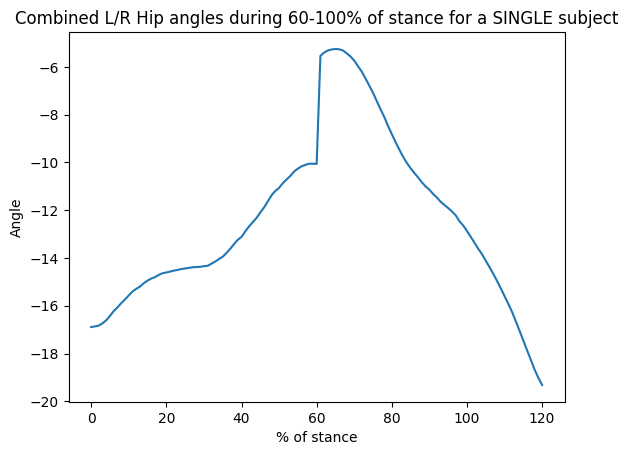

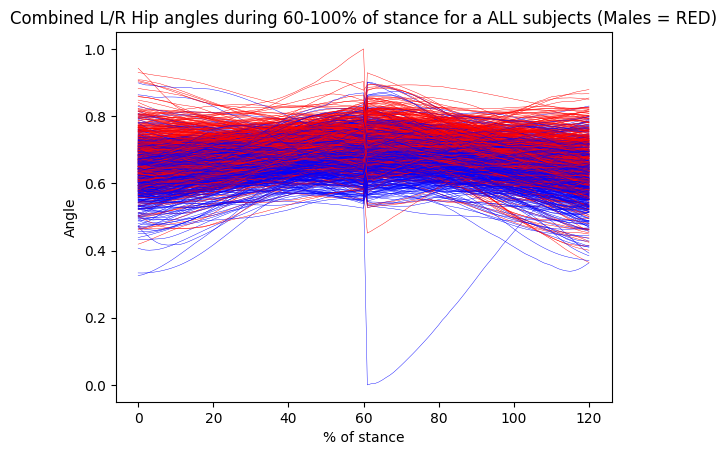

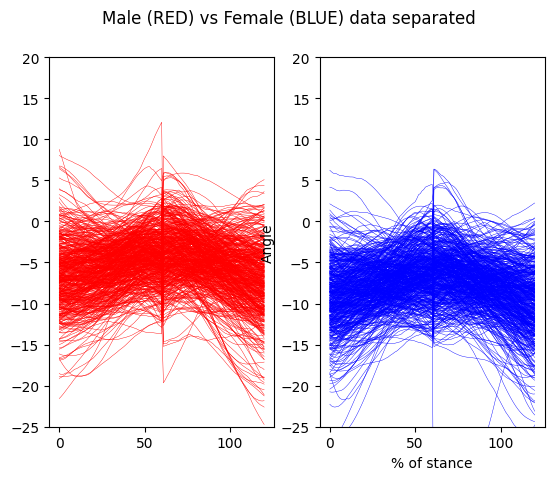

In [28]:
#visualize data from data loader. Visualize single subject then and all subjects

plt.plot(timeseries[0].to('cpu').numpy())
plt.title("Combined L/R Hip angles during 60-100% of stance for a SINGLE subject")
plt.xlabel("% of stance")
plt.ylabel("Angle")
plt.show()

for i in range(len(timeseries)):

    norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)

    #norm_vals = torch.from_numpy(norm_vals).float()

    if labels[i] == 1:
        plt.plot(norm_vals[i], label = "Male", color = 'red',linewidth=0.3)
        #plt.plot(timeseries[i].to('cpu').numpy(), color = 'red',linewidth=0.3)
    else:
        #plt.plot(timeseries[i].to('cpu').numpy(), color = 'blue',linewidth=0.3)
        plt.plot(norm_vals[i], label = "Female", color = 'blue',linewidth=0.3)


plt.title("Combined L/R Hip angles during 60-100% of stance for a ALL subjects (Males = RED)")
plt.xlabel("% of stance")
plt.ylabel("Angle")
#plt.legend(loc ="upper right")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Male (RED) vs Female (BLUE) data separated')

for i in range(len(timeseries)):
    if labels[i] == 1:
        ax1.plot(timeseries[i].to('cpu').numpy(), label = "Male", color = 'red',linewidth=0.3)
    else:
        ax2.plot(timeseries[i].to('cpu').numpy(), label = "Female", color = 'blue',linewidth=0.3)


ax1.set_ylim([-25, 20])
ax2.set_ylim([-25, 20])
plt.xlabel("% of stance")
plt.ylabel("Angle")
#plt.legend(loc ="upper right")
plt.show()

To the naked eye it would seem difficult to separate anything out of these plots. However, there does indeed appear to be a pattern with red (males) trending higher than blue (females). Let's see how the models do.

Define Model

First let's define out GRU model

In [29]:
class GRUNet(nn.Module):

    '''
        Class GRUNet: Gated Recurrent Unit (GRU) model

            Params: input_dim (int):    Dimension of the input data. For this work as the time dimension is normalized (0-100), the only dimension is the from the angular data. 
                                        Therefore the input dimension is 1.
                    hidden_dim (int): Dimension of the hidden layer. Many values were tried here and 124 produced the most consistent results
                    output_dim (int): The calculated maximum angle of the batch
                    n_layers (int): Number of stacked GRUs. Once again a few values were attempted here with 2 producing the most consistent results.
                    drop_prob (float): Dropout layer with drop probability between 0-1. A few different values were also attempted here with 0.2 producing consistent results.

        Returns:    out (tensor):  output features (h_t) from the last layer of the GRU
                    h (tensor): Final hidden layer of the model
        

    '''
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        # out = self.fc(out[:,-1])
        
        #because we are using BCEloss, the final action must be to pass through a sigmoid layer.
        out = self.sigmoid(out)

        # x = torch.relu(self.fcin(x))
        # x = torch.sigmoid(self.fcout(x))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

Next let's define our LSTM model

In [30]:
class LSTMNet(nn.Module):

    '''
        Class LSTMNet: long short-term memory networks LSTM model

            Params: input_dim (int):    Dimension of the input data. For this work as the time dimension is normalized (0-100), the only dimension is the from the angular data. 
                                        Therefore the input dimension is 1.
                    hidden_dim (int): Dimension of the hidden layer. Many values were tried here and 124 produced the most consistent results
                    output_dim (int): The calculated maximum angle of the batch
                    n_layers (int): Number of stacked GRUs. Once again a few values were attempted here with 2 producing the most consistent results.
                    drop_prob (float): Dropout layer with drop probability between 0-1. A few different values were also attempted here with 0.2 producing consistent results.

        Returns:    out (tensor):  output features (h_t) from the last layer of the LSTM
                    h (tensor): Final hidden layer of the model
        

    '''
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.sigmoid = nn.Sigmoid()
        
        self.first_layer = nn.Linear(input_dim, 32)
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first = True, dropout=drop_prob)
        #self.lstm = nn.LSTM(32, hidden_dim, n_layers, batch_first = True, dropout=drop_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        
    def forward(self, x, h):
        #x = self.first_layer(self.relu(x))
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.sigmoid(out)
        
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

Next let's define our training loop.

In [31]:
import torch.optim as optim
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloader):

    '''
        Function train_model: training loop for neural network model

            Params: model (nn.module):  The input model, for this work either GRU or LSTM
                    criterion (int): Loss function, for this work this is the BCEloss
                    optimizer (int): The chosen optimizer, for this work this is ADAM with some tested extra parameters
                    scheduler (int): If desired a learning rate scheduler can be applied
                    num_epochs (int): Number of epochs to train the data. After testing 128 was found to produce consistent results

            Returns:loss_all (list):  List containing the calulated loss of each iteration of the training loop
                    execution_time (float): The cumulative training time for the entire training loop
        

    '''


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inputs = timeseries
    labels = []
    loss_all = []
    start = time.time()

    

    for epoch in range(num_epochs):

        for i, batch in enumerate(dataloader):

            norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)

            norm_vals = torch.from_numpy(norm_vals).float()
            # inputs = batch['timeseries'].cuda()
            inputs = norm_vals.cuda()
            labels = batch['label']

            h = model.init_hidden(len(inputs))
            #h = model2.init_hidden(inputs.size(1))

            optimizer.zero_grad()

            #for input in inputs:
            output , h = model(inputs.view(len(inputs),inputs.size(1),1),h)

            #for debugging
            # for parameter in model.parameters():
            #     print(parameter)

            labels = labels.type(torch.LongTensor)
            #loss = criterion(output, labels.to(device))
            loss = criterion(output.squeeze(),labels.float().to(device))
            loss.backward()

            optimizer.step()
            
            loss_all.append(loss.item())
            
        if scheduler:
            scheduler.step()

        if (epoch%16 == 0):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, len(timeseries)//len(X_train), loss.item()))
 
    end = time.time() 

    execution_time = end - start
    
    return loss_all, execution_time       

Define model evaluation (accuracy)

In [32]:
from sklearn.metrics import classification_report

def evaluate_model(model):

    '''
        Function evaluate_model: training loop for neural network model

            Params: model (nn.module):  The input model, for this work either GRU or LSTM

            Returns:accuracy (list):  List containing the calulated loss of each iteration of the training loop
                    execution_time (float): The cumulative training time for the entire training loop
        

    '''

    correct = 0
    total = 0
    batch_size = len(X_test)
    test_dataloader = DataLoader(HipBiomechanicsDataset(X_test, transform=None),
                            batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)

            norm_vals = torch.from_numpy(norm_vals).float()
            # inputs = batch['timeseries'].cuda()
            inputs = norm_vals.cuda()
            labels = batch['label']
            labels = labels.type(torch.LongTensor)

            h = model.init_hidden(len(inputs))
            #h = model2.init_hidden(inputs.size(1))
            output , h = model(inputs.view(len(inputs),inputs.size(1),1),h)

            # _, predicted = torch.max(output.data, 1)

            # predicted = predicted.type(torch.LongTensor)
            #predicted = output.data.max(1, keepdim=True)[1].flatten()
            predicted = (output > 0.50).long()

            predicted = predicted.type(torch.LongTensor)
            #print(predicted)

            total += labels.size(0)
            #correct += (predictions == y).sum()
            correct += (predicted.squeeze() == labels).sum()

            accuracy = 100 * correct / total

            print('Accuracy of the model on the test set: {:.2f}%'.format(100 * correct / total))

            print('Classification Report: \n', classification_report(labels, predicted))

            return accuracy

Finally, let's run through some different hyper-parameters and evaluate

Epoch [1/128], Step [2/1], Loss: 0.6936
Epoch [17/128], Step [2/1], Loss: 0.6927
Epoch [33/128], Step [2/1], Loss: 0.6920
Epoch [49/128], Step [2/1], Loss: 0.6898
Epoch [65/128], Step [2/1], Loss: 0.6824
Epoch [81/128], Step [2/1], Loss: 0.6096
Epoch [97/128], Step [2/1], Loss: 0.6067
Epoch [113/128], Step [2/1], Loss: 0.5744
Accuracy of the model on the test set: 68.93%
Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.75      0.71        53
           1       0.70      0.62      0.66        50

    accuracy                           0.69       103
   macro avg       0.69      0.69      0.69       103
weighted avg       0.69      0.69      0.69       103

Epoch [1/128], Step [2/1], Loss: 1.3460
Epoch [17/128], Step [2/1], Loss: 0.6937
Epoch [33/128], Step [2/1], Loss: 0.6929
Epoch [49/128], Step [2/1], Loss: 0.6929
Epoch [65/128], Step [2/1], Loss: 0.6936
Epoch [81/128], Step [2/1], Loss: 0.6927
Epoch [97/128], Step [2/1], L

c:\Users\allan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Epoch [1/128], Step [2/1], Loss: 0.6918
Epoch [17/128], Step [2/1], Loss: 0.6873
Epoch [33/128], Step [2/1], Loss: 0.6612
Epoch [49/128], Step [2/1], Loss: 0.6462
Epoch [65/128], Step [2/1], Loss: 0.6403
Epoch [81/128], Step [2/1], Loss: 0.6206
Epoch [97/128], Step [2/1], Loss: 0.6269
Epoch [113/128], Step [2/1], Loss: 0.5970
Accuracy of the model on the test set: 67.96%
Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.79      0.72        53
           1       0.72      0.56      0.63        50

    accuracy                           0.68       103
   macro avg       0.69      0.68      0.67       103
weighted avg       0.69      0.68      0.67       103

Epoch [1/128], Step [2/1], Loss: 0.6152
Epoch [17/128], Step [2/1], Loss: 0.6133
Epoch [33/128], Step [2/1], Loss: 0.6029
Epoch [49/128], Step [2/1], Loss: 0.6189
Epoch [65/128], Step [2/1], Loss: 0.5910
Epoch [81/128], Step [2/1], Loss: 0.6082
Epoch [97/128], Step [2/1], L

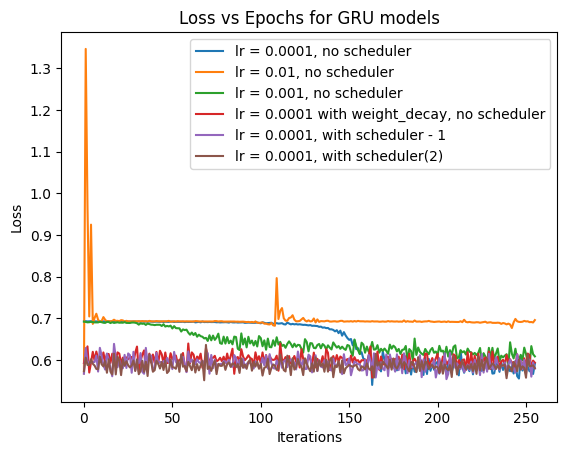

In [33]:
import plotly.graph_objects as px

model_name = 'GRU'
num_epochs=128
accuracy = []
hyper_parameter = []
execution_time = []

if (model_name == 'LSTM'):
    model = LSTMNet(input_dim=1, hidden_dim=124, output_dim = 1, n_layers=2).to(device)
    #get error Windows not yet supported for torch.compile
    #model = torch.compile(model)
elif (model_name == 'GRU'):
    model = GRUNet(input_dim=1, hidden_dim=124, output_dim = 1, n_layers=2).to(device)
    #get error Windows not yet supported for torch.compile
    #model = torch.compile(model)

# Define Loss, Optimizer since this is a binary classification problem, use BCE loss
#criterion = nn.CrossEntropyLoss() -> this one does work but I read it's not necessarily appropriate for binary classification.
#criterion2 = torch.nn.BCEWithLogitsLoss() this one was supposed to apply to sigmoid for you, but I couldn't get it to work


criterion = torch.nn.BCELoss()


lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=False, num_epochs = num_epochs, dataloader = dataloader)
ax1 = plt.plot(np.array(loss_vals),label="lr = 0.0001, no scheduler")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.0001, no scheduler")

#view effect of 2 different learning rates
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=False, num_epochs = num_epochs, dataloader = dataloader)
ax1 = plt.plot(np.array(loss_vals),label="lr = 0.01, no scheduler")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.01, no scheduler")

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=False, num_epochs = num_epochs, dataloader = dataloader)
plt.plot(np.array(loss_vals), label= "lr = 0.001, no scheduler")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.001, no scheduler")

#try switching out the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=False, num_epochs = num_epochs, dataloader = dataloader)
plt.plot(np.array(loss_vals),label= "lr = 0.0001 with weight_decay, no scheduler")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.0001 with weight_decay, no scheduler")

#finally attempt a scheduler
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schelduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=schelduler, num_epochs = num_epochs, dataloader = dataloader)
plt.plot(np.array(loss_vals),label= "lr = 0.0001, with scheduler - 1")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.0001, with scheduler(1)")

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schelduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1, verbose=False)
loss_vals, timer = train_model(model, criterion, optimizer, scheduler=schelduler, num_epochs = num_epochs, dataloader = dataloader)
plt.plot(np.array(loss_vals),label= "lr = 0.0001, with scheduler(2)")
model_accuracy = evaluate_model(model)
accuracy.append(model_accuracy.item())
execution_time.append(timer)
hyper_parameter.append("GRU - lr = 0.0001, with scheduler(2)")

plt.legend(loc ="upper right")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for GRU models")
plt.show()

#the matplotlib graphs make it difficult to see what the final accuracy values are on the graph. Use plotly as it has built in tooltips.

# plt.bar(hyper_parameter,accuracy)
# plt.xticks(rotation=90)
# plt.xlabel("Hyper Parameters")
# plt.ylabel("Model Accuracy")
# plt.title("Model Accuracy for GRU")
# plt.show()

# plt.bar(hyper_parameter,execution_time)
# plt.xticks(rotation=90)
# plt.xlabel("Hyper Parameters")
# plt.ylabel("Training time")
# plt.title("Training time for GRU models")
# plt.show()


#create plotly graphing 

x = hyper_parameter
 
plot = px.Figure(data=[px.Bar(
    name = 'Accuracy',
    x = x,
    y = accuracy
   )
],

layout=px.Layout(
        title=px.layout.Title(text="Model Accuracy")

)
)

plot.update_layout(yaxis_range=[0,100])
plot.update_xaxes(tickangle=90)

plot.show()

plot = px.Figure(data=[px.Bar(
    name = 'Execution Time',
    x = x,
    y = execution_time
   )
],

layout=px.Layout(
        title=px.layout.Title(text="Model Execution Time")

)
)

plot.update_xaxes(tickangle=90)

plot.show()

From the graphs above a few insights are gained. First a learning rate between 0.001-0.0001 is most appropriate for this problem with ~100 epochs being sufficient for the gradient decent. Although adding the schedulers didn't appear to effect the accuracy of the models, they didn't appear to achieve any kind of gradient decent as they simply bounced around without decending. All training took about the same time, about 100 seconds on my machine. Having run through the training multiple times, the model which performed best was not consistent. However, usually the schedulers performed worse than the models with the schedulers and a learning rate of 0.01 always performed worse.  

Epoch [1/128], Step [2/1], Loss: 0.6921
Epoch [17/128], Step [2/1], Loss: 0.6926
Epoch [33/128], Step [2/1], Loss: 0.6924
Epoch [49/128], Step [2/1], Loss: 0.6926
Epoch [65/128], Step [2/1], Loss: 0.6864
Epoch [81/128], Step [2/1], Loss: 0.6044
Epoch [97/128], Step [2/1], Loss: 0.5704
Epoch [113/128], Step [2/1], Loss: 0.5715
Accuracy of the model on the test set: 70.87%
Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.75      0.73        53
           1       0.72      0.66      0.69        50

    accuracy                           0.71       103
   macro avg       0.71      0.71      0.71       103
weighted avg       0.71      0.71      0.71       103



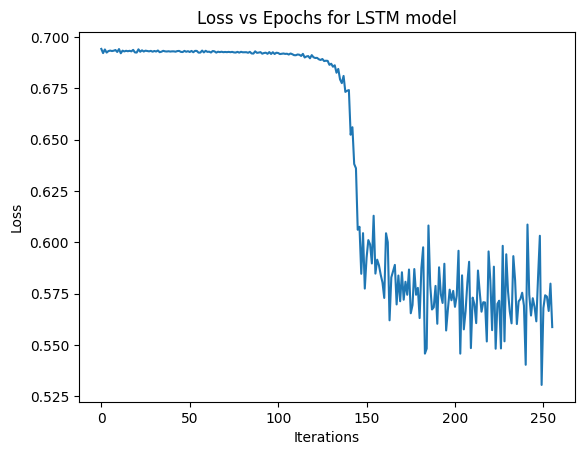

In [34]:
import plotly.graph_objects as px

model_name = 'LSTM'
lr = 0.0001
num_epochs=128

if (model_name == 'LSTM'):
    model = LSTMNet(input_dim=1, hidden_dim=124, output_dim = 1, n_layers=2).to(device)
elif (model_name == 'GRU'):
    model = GRUNet(input_dim=1, hidden_dim=124, output_dim = 1, n_layers=2).to(device)

# Define Loss, Optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_vals,timer = train_model(model, criterion, optimizer, scheduler=False, num_epochs = num_epochs, dataloader = dataloader)
model_accuracy = evaluate_model(model)

execution_time.append(timer)
hyper_parameter.append("LSTM - lr = 0.001, no scheduler")
accuracy.append(model_accuracy)

plt.plot(np.array(loss_vals),label= "ADAM, lr = 0.001")
plt.title("Loss vs Epochs for LSTM model")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

x = hyper_parameter
 
plot = px.Figure(data=[px.Bar(
    name = 'Accuracy',
    x = x,
    y = accuracy
   )
],

layout=px.Layout(
        title=px.layout.Title(text="Model Accuracy")

)
)
plot.update_xaxes(tickangle=90)
plot.update_layout(yaxis_range=[0,100])
plot.show()
 
plot = px.Figure(data=[px.Bar(
    name = 'Execution Time',
    x = x,
    y = execution_time
   )
],

layout=px.Layout(
        title=px.layout.Title(text="Model Execution Time")

)
)

plot.update_xaxes(tickangle=90)

plot.show()

The LSTM model appears to have performed about the same as the GRU models. As expected the LSTM was slower to train, however it was not consistent. On some runs it would be the same as the GRU models, sometimes about 40% longer, and sometimes as on this run much longer (300x). 

Next we will apply these same data to a couple machine learning algorithms to see if the neural network performed better at the classification problem. First let's begin with a default gradient boostin classifier. Finally we will finish with a gridsearched gradient boosting classifier. 

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


ml_dataloader = DataLoader(HipBiomechanicsDataset(X_train, transform=None),
                        batch_size=X_train.shape[0], shuffle=True)

batch_size = len(X_test)
test_dataloader = DataLoader(HipBiomechanicsDataset(X_test, transform=None),
                        batch_size=batch_size, shuffle=False)

for i, batch in enumerate(ml_dataloader):

    norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)
    labels = batch['label'].cpu().detach().numpy()
    gbc_model = GradientBoostingClassifier(random_state = 42)
    rf_model = RandomForestClassifier(random_state=42)
    gbc_model.fit(norm_vals, labels)
    rf_model.fit(norm_vals, labels)

    

for i, batch in enumerate(test_dataloader):
    norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)   
    labels = batch['label'].cpu().detach().numpy() 
    gbc_y_pred = gbc_model.predict(norm_vals)
    gbc_accuracy = accuracy_score(labels, gbc_y_pred)
    
    rf_y_pred = rf_model.predict(norm_vals)
    fr_accuracy = accuracy_score(labels, rf_y_pred)

print('Accuracy Score GBC: \n', accuracy_score(labels, gbc_y_pred))
print('Classification Report GBC: \n', classification_report(labels, gbc_y_pred))

print('Accuracy Score RF: \n', accuracy_score(labels, rf_y_pred))
print('Classification Report RF: \n', classification_report(labels, rf_y_pred))


Accuracy Score GBC: 
 0.6893203883495146
Classification Report GBC: 
               precision    recall  f1-score   support

           0       0.71      0.68      0.69        53
           1       0.67      0.70      0.69        50

    accuracy                           0.69       103
   macro avg       0.69      0.69      0.69       103
weighted avg       0.69      0.69      0.69       103

Accuracy Score RF: 
 0.6699029126213593
Classification Report RF: 
               precision    recall  f1-score   support

           0       0.69      0.64      0.67        53
           1       0.65      0.70      0.67        50

    accuracy                           0.67       103
   macro avg       0.67      0.67      0.67       103
weighted avg       0.67      0.67      0.67       103



I ran the below code, but it takes a long time and adds nothing. It would appear the default parameters of the gradient boosting algorithm are already optimized for this problem. Therefore re-running the gridsearch algorithm is not advisable.

In [33]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedGroupKFold

# param_grid_gbm = {
#                   'n_estimators': [20, 50, 100],
#                   #'max_features' : ['auto','sqrt'],
#                   'min_samples_leaf': [1, 2, 4],
#                   "min_samples_split": [2,4,6],
#                   'max_depth' : [3,4,5,10],
#                   }

# gbm = GradientBoostingClassifier(random_state=42)

# kf = StratifiedGroupKFold(n_splits=5, shuffle=True)

# grid_gbm = GridSearchCV(estimator=gbm, 
#                         param_grid=param_grid_gbm, 
#                         #cv=kf,n_jobs = -1)
#                         cv=kf,n_jobs = -1)


# for i, batch in enumerate(ml_dataloader):

#     norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)
#     labels = batch['label'].cpu().detach().numpy()
#     gbc_model = GradientBoostingClassifier(random_state = 42)
#     grid_gbm.fit(norm_vals, labels)

# grid_gbm_accuracy = grid_gbm.best_score_

# params = grid_gbm.best_params_
# gbc_best_sub_model = GradientBoostingClassifier(**params, random_state = 42)

# for i, batch in enumerate(ml_dataloader):
#     norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)
#     labels = batch['label'].cpu().detach().numpy()
#     gbc_best_sub_model.fit(norm_vals, labels)


# for i, batch in enumerate(test_dataloader):
#     norm_vals = normalize(batch['timeseries'].cpu().detach().numpy(), min_angle_all, max_angle_all)   
#     labels = batch['label'].cpu().detach().numpy() 
#     y_pred = gbc_best_sub_model.predict(norm_vals)   

# print('Accuracy Score: \n', accuracy_score(labels, y_pred))
# print('Classification Report: \n', classification_report(labels, y_pred))

c:\Users\allan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



Accuracy Score: 
 0.6893203883495146
Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.72      0.70        53
           1       0.69      0.66      0.67        50

    accuracy                           0.69       103
   macro avg       0.69      0.69      0.69       103
weighted avg       0.69      0.69      0.69       103



Discussion

This project was always more about the journey than the destination. In the past in these sorts of courses I've typically picked datasets on the basis of how much they amused me. However, for this one I wanted to tackle a question where the outcome was a little less clear. Typically in the biomechanics world, research has focused on "descriptive variables" such as peak angles, or excursions (difference between peak/min angle), but far less work as been done on any kind of waveform analysis. So I set out with a straightforward goal, can I train a neural network to recognise the gender of a subject based on a waveform analysis of their joint angles? Someone doesn't need to be involved in the field of biomechanics to know that males and females are anatomically different. Based on some previous research (https://pubmed.ncbi.nlm.nih.gov/12689785/), it is accepted that their biomechanics also differ, specifically in the hip joint. As such, this is where I focused my attention, on training the algorithm on frontal plane hip joint angles. 

However, training the model to make any useful predictions proved a more arduous task than I had anticipated. Initially, the model would only return predictions of a single class (all male or all female), which meant that the model accuracy stayed pinned at 50% for some time, which meant the model as all but useless. A day spent hyper parameter tuning, and learning a lot in general, proved moderately successful. At this point I could get the accuracy to about 60%. To achieve better accuracy I had to perform three tasks. First, I merged both left/right angle data into a single waveform. This would allow more waveform data to be fed into the model. Next, the differences between men and woman are most pronounced in the latter 60% of stance (when your foot is on the ground when you are walking/running). So only included this part of the waveform into the training and testing data. Finally, and likely most importantly, I scaled the data between 0-1 before feeding it into the model. With these steps, I was able to achieve a best accuracy of 71% with the GRU model. A solid C-. 

As a final step I fed the waveform data into a gradient boosting classifer and a random forest machine learning algorithm. This model achieved an accuracy as 69% and 67% respectively, which was comparabled to the LSTM and GRU neural netowrk models. It's entirely possible with more hyper-parameter tuning that I could improve the accuracy of the GRU, however time constraints made more tweeking not practical. So in conclusion the model was moderately successful. As is typically the case in human based data, there is a lot of noise present in the data. Human beings are not all alike, and are sometimes don't produce the most repeatable data. So, I find it to be a decently good result to achieve >70% accuracy for determining someones gender based solely on the angle of their hip joint.  